# Q3: Effect of Activation Functions on CNN Performance  
## Experiment: ReLU Activation

This notebook investigates how the **ReLU (Rectified Linear Unit)** activation function
affects the performance of a convolutional neural network (CNN) on the Fashion-MNIST dataset.

The goal of this experiment is to understand whether Sigmoid is suitable for
deep convolutional architectures and to compare its behaviour with Sigmoid and
LeakyReLU models trained under identical conditions.The goal of this experiment is to understand whether Sigmoid is suitable for
deep convolutional architectures and to compare its behaviour with ReLU and
LeakyReLU models trained under identical conditions.

To ensure a fair comparison, the dataset, network architecture, optimiser, learning rate,
and training procedure are kept identical to the other Q3 experiments
(LeakyReLU, Sigmoid, and Tanh). Only the activation function differs.


## Experimental Setup

- **Dataset:** Fashion-MNIST (10 classes)
- **Input:** 28 × 28 grayscale images
- **Train / Validation split:** 80% / 20%

### CNN Architecture
- Conv2D: 1 → 8 channels, kernel size 3
- ReLU activation
- MaxPooling: 2 × 2
- Conv2D: 8 → 16 channels, kernel size 3
- ReLU activation
- MaxPooling: 2 × 2
- Fully connected layer: 128 units
- ReLU activation
- Output layer: 10 units

### Training Configuration
- **Loss function:** CrossEntropyLoss
- **Optimiser:** Adam
- **Learning rate:** 0.01
- **Epochs:** 20

Only the **activation function** differs between experiments.


## Imports and Setup

We import PyTorch, supporting libraries, and helper functions defined in
`functions.py`. These helper functions are shared across Q1, Q2, and Q3 to
ensure consistency and reproducibility.


In [116]:
import sys
sys.path.append("..")

from functions import get_data, data_split_train_val

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

## Dataset: Fashion-MNIST

Fashion-MNIST consists of 28×28 grayscale images across 10 clothing categories.
It is a commonly used benchmark dataset for image classification and is
well-suited for analysing CNN behaviour.

In [117]:
# Load Fashion-MNIST (normalised to [0,1])
X, y = get_data("../data/fashion-mnist_test.csv")

# Train/validation split
X_train, X_val, y_train, y_val = data_split_train_val(X, y)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)

Train shape: (8000, 784)
Validation shape: (2000, 784)


In [118]:
# convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()

X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).long()

In [119]:
print("Before reshape:")
print("X_train_tensor shape:", X_train_tensor.shape)
print("X_val_tensor shape:", X_val_tensor.shape)

Before reshape:
X_train_tensor shape: torch.Size([8000, 784])
X_val_tensor shape: torch.Size([2000, 784])


In [120]:
num_train = X_train_tensor.shape[0]
num_val = X_val_tensor.shape[0]

print(num_train, num_val)

8000 2000


In [121]:
X_train_tensor = X_train_tensor.reshape(num_train, 1, 28, 28)
X_val_tensor = X_val_tensor.reshape(num_val, 1, 28, 28)
print("X_train_tensor reshape:", X_train_tensor.shape)
print("X_val_tensor reshape:", X_val_tensor.shape)

X_train_tensor reshape: torch.Size([8000, 1, 28, 28])
X_val_tensor reshape: torch.Size([2000, 1, 28, 28])


In [122]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## CNN Architecture with ReLU Activation

The CNN below uses ReLU activations after each convolutional layer and the first
fully connected layer. This matches the architecture used in the other activation
function experiments, allowing a direct comparison of learning behaviour and accuracy.


In [123]:
class CNN_ReLU(nn.Module):
    def __init__(self):
        super().__init__()

        self.activation = nn.ReLU()

        self.conv1 = nn.Conv2d(1, 8, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3)

        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool(x)
        
        x = self.activation(self.conv2(x))
        x = self.pool(x)

        x = torch.flatten(x, 1)

        x = self.activation(self.fc1(x))
        return self.fc2(x)

## Training Configuration

The model is trained using the Adam optimiser and CrossEntropy loss.
All hyperparameters are identical to those used in other activation
function experiments.


In [124]:
data = CNN_ReLU()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(data.parameters(), lr=0.01)

## Training Loop

Both training and validation loss and accuracy are recorded at each epoch
to analyse learning behaviour.


In [125]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [126]:
epochs = 20

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Forward pass (training)
    outputs = data(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Training accuracy
    train_preds = torch.argmax(outputs, 1)
    train_acc = (train_preds == y_train_tensor).float().mean().item()
    
    # Validation loss and accuracy
    with torch.no_grad():
        val_outputs = data(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_preds = torch.argmax(val_outputs, 1)
        val_acc = (val_preds == y_val_tensor).float().mean().item()
    
    # Store history
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(
        f"Epoch {epoch+1}/{epochs}, "
        f"Train Loss: {loss.item():.4f}, "
        f"Val Loss: {val_loss.item():.4f}, "
        f"Val Acc: {val_acc:.4f}"
    )

Epoch 1/20, Train Loss: 2.3113, Val Loss: 2.2474, Val Acc: 0.1945
Epoch 2/20, Train Loss: 2.2485, Val Loss: 2.0898, Val Acc: 0.3585
Epoch 3/20, Train Loss: 2.0943, Val Loss: 1.8120, Val Acc: 0.4560
Epoch 4/20, Train Loss: 1.8117, Val Loss: 1.4996, Val Acc: 0.4840
Epoch 5/20, Train Loss: 1.5092, Val Loss: 1.3148, Val Acc: 0.4825
Epoch 6/20, Train Loss: 1.3252, Val Loss: 1.2706, Val Acc: 0.5250
Epoch 7/20, Train Loss: 1.2965, Val Loss: 1.4017, Val Acc: 0.5285
Epoch 8/20, Train Loss: 1.3694, Val Loss: 1.4505, Val Acc: 0.4900
Epoch 9/20, Train Loss: 1.4490, Val Loss: 1.2886, Val Acc: 0.5020
Epoch 10/20, Train Loss: 1.3186, Val Loss: 1.2371, Val Acc: 0.5565
Epoch 11/20, Train Loss: 1.2558, Val Loss: 1.1419, Val Acc: 0.5630
Epoch 12/20, Train Loss: 1.1505, Val Loss: 1.0414, Val Acc: 0.5930
Epoch 13/20, Train Loss: 1.0531, Val Loss: 1.0334, Val Acc: 0.5750
Epoch 14/20, Train Loss: 1.0443, Val Loss: 1.0275, Val Acc: 0.6065
Epoch 15/20, Train Loss: 1.0399, Val Loss: 1.0283, Val Acc: 0.6155
Epoc

In [127]:
print("Final validation accuracy:", val_accuracies[-1])

Final validation accuracy: 0.7235000133514404


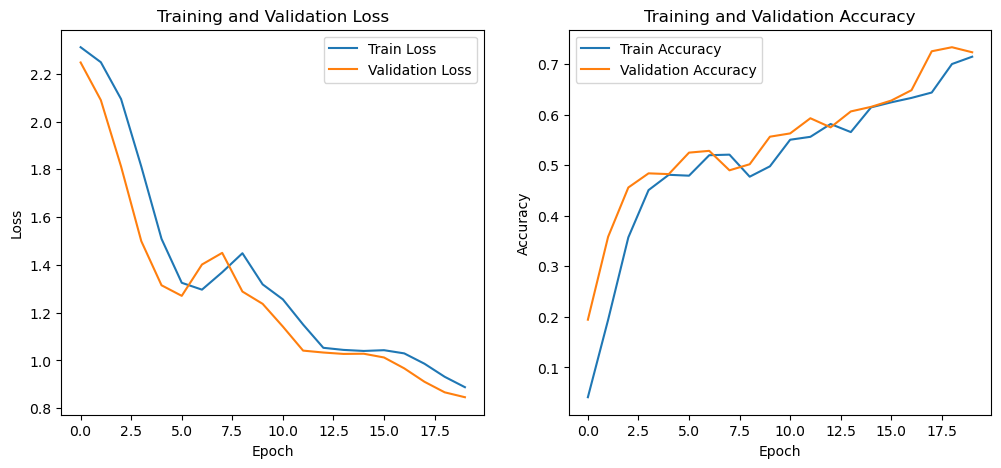

In [128]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

## Results

The following plots show the training and validation loss and accuracy
over the 20 training epochs.


## Results Interpreatation
ReLU enables faster convergence compared to sigmoid-based activations
due to its non-saturating behaviour for positive inputs.

From the results, the model reaches a final validation accuracy of approximately **72%**.
The loss decreases steadily across epochs, indicating stable learning.
Minor fluctuations in validation accuracy are expected due to stochastic optimisation.




## Comparison with Other Activation Functions

Compared to Sigmoid and LeakyReLU models trained under identical conditions, ReLU provides a strong baseline in terms of convergence speed and final validation accuracy. Unlike Sigmoid, ReLU avoids activation saturation for positive inputs, enabling more effective gradient propagation and substantially better learning performance. While LeakyReLU achieves slightly smoother convergence by allowing small gradients for negative activations, ReLU performs competitively overall and demonstrates that simple non-linear activations can be highly effective in CNN architectures.


## Conclusion

This experiment shows that ReLU is a reliable and effective activation function for convolutional neural networks applied to the Fashion-MNIST dataset. It enables faster convergence and significantly higher accuracy than Sigmoid, while offering performance comparable to LeakyReLU. These results highlight ReLU as a strong default choice for CNNs and emphasise the importance of selecting appropriate activation functions to ensure stable and efficient training.